# Programmatic Molecular Docking 

### Based on Vina-derived Smina. Obabel is used to calculate the protein charges. The docking grid is defined as the centre of the native ligand.

- This notebook is written by https://github.com/quantaosun
- what you get is ***the docking score + docked complex + a 2D image + a 3D interaction pymol session file*** 
- the docked complex and 2D image are readily to be used, The 3D pymol session need to be downloaded to a local pymol for further polish if you want a publication quality

# Please provide PDB ID and ligand structure you want to dock with

In [44]:
#@title Input expected from the user
path = "." #@param {type:"string"}
%cd '{path}'
PDB_ID = "3HTB" #@param {type:"string"}
pdb = PDB_ID + ".pdb"
! wget https://files.rcsb.org/download/$pdb
#@title Ligand three-letter name
Ligand = "JZ4" #@param {type:"string"}
smiles = "c1ccccc1" #@param {type:"string"}


/home/jovyan
--2023-03-18 09:58:44--  https://files.rcsb.org/download/3HTB.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.234
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘3HTB.pdb.2’

3HTB.pdb.2              [ <=>                ] 161.13K  1.01MB/s    in 0.2s    

2023-03-18 09:58:44 (1.01 MB/s) - ‘3HTB.pdb.2’ saved [164997]



# Docking in progress, usually around 3-10 min

In [45]:
!wget --no-check-certificate https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static 2>&1 1>/dev/null
!chmod u+x smina.static

--2023-03-18 09:58:45--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 104.18.10.128, 104.18.11.128, 2606:4700::6812:b80, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.10.128|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABkFYtVu_UWxsHk9v8BmsD50QZsvEhEly5TrMA5IhJWhY-svZAtXPN7ytSkauOPLcF9xlw0OkXcT4UY7kNfQVDtgTJbFg%3D%3D&use_mirror=cytranet&r= [following]
--2023-03-18 09:58:45--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABkFYtVu_UWxsHk9v8BmsD50QZsvEhEly5TrMA5IhJWhY-svZAtXPN7ytSkauOPLcF9xlw0OkXcT4UY7kNfQVDtgTJbFg%3D%3D&use_mirror=cytranet&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: 

In [46]:
import sys
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
print(rdBase.rdkitVersion)

2022.09.4


## Prepare receptor

In [47]:
!grep -v -e "{Ligand}" -e "SO4" -e "CONECT" -e "HOH" -e "EDO" -e "IOD" {PDB_ID}.pdb >  {PDB_ID}-receptor.pdb
!grep "{Ligand}" {PDB_ID}.pdb > {PDB_ID}-{Ligand}.pdb


## Variable assignment

In [48]:
Protein_PDB_file_name = PDB_ID + '-receptor.pdb'
ligand_name = PDB_ID + '-' + Ligand + '.pdb'

## PDBFixer to prepare the receptor

In [49]:
!pdbfixer  {Protein_PDB_file_name} --ph=7  --replace-nonstandard --add-residues 
!cat output.pdb > receptor.pdb

## Caculating charges for receptor

In [50]:
#@title Target and native ligand preparation before docking
#!obabel {Protein_PDB_file_name} -xr -O receptor.pdbqt
!obabel receptor.pdb -xr -O receptor.pdbqt
!obabel {ligand_name} -O native_ligand.pdbqt

1 molecule converted
1 molecule converted


## Prepare ligand

In [51]:
#@title Convert SMILE strings to SDF format
!echo "{smiles}" > ligand2.smi
!obabel ligand2.smi -osdf -O small.sdf --gen3d

1 molecule converted


In [52]:
#@title Define small ligand path and number
# File locations
sdfFilePath = 'small.sdf' #@param {type:"string"}
ConfoutputFilePath = 'small_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

1

In [53]:
#@title SDF conformation generation for small molecule

import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time: 0:00:00 |################################|


## Define Docking inputs variables

In [54]:
#@title 👋 Input names needed for Dock1
ProteinForDocking = "receptor.pdbqt" #@param {type:"string"}
LigandFromProtein = "native_ligand.pdbqt" #@param {type:"string"}
Docked_out_FilePath = "Docked.pdb" #@param {type:"string"}
FlexibleDockedFilePath = "FlexibleDocked.sdf.gz" #@param {type:"string"}

## Docking 

In [55]:
#@title  Normal Docking (docking box is 8Å greater than the ligand specified. The –exhaustiveness is 8 )
!./smina.static --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}'  -o '{Docked_out_FilePath}'

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -

## 3D Visualization  & Download Docked.pdb and protein. 

In [56]:
import MDAnalysis as mda
import prolif as plf

In [57]:
!obabel -ipdb Docked.pdb -opdb -O Docked.pdb -m -h

9 molecules converted
9 files output. The first is Docked1.pdb


In [58]:
!obabel -ipdb Docked.pdb -osdf -O Docked.sdf  -h

9 molecules converted


In [59]:
import py3Dmol

def drawit2(m,confId=-1):
    mb = Chem.MolToMolBlock(m,confId=confId)
    p = py3Dmol.view(width=400, height=400)
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p

def DrawComplex(protein,ligand):
    complex_pl = Chem.MolToPDBBlock(Chem.CombineMols(protein,ligand))
    #complex_mol=Chem.CombineMols(receptor,mols[-1])
    view = py3Dmol.view(width=600,height=600)
    view.addModel(complex_pl,'pdb')
    #view.addModel(Chem.MolToMolBlock(mols[0]),'sdf')
    chA = {'chain':['H','L','I']}
    chB = {'resn':'UNL'}
    view.setStyle(chA,{'cartoon': {'color':'spectrum'}})
    #view.setStyle(chA,{'lines': {}})
    view.addSurface(py3Dmol.VDW,{'opacity':0.8}, chB)
    view.setStyle(chB,{'stick':{}})
    view.zoomTo()
    return view   


In [60]:
#@title Define display style
#@title Define receptor name
TargetProtein = Protein_PDB_file_name
def DrawDocking(protein,ligand):
     complex_pl = Chem.MolToPDBBlock(protein)
     docked_pdb = Chem.MolToPDBBlock(ligand)
     viewer = py3Dmol.view(width=800,height=800)
     viewer.addModel(complex_pl,'pdb')
     viewer.addModel(docked_pdb)
     prot = {'resn': ["DMS", "UNL", "SO4", "LIG", "HOH", "Cl"], 'invert': 1}  #define prot as all except list
     viewer.setStyle(prot,{'cartoon': {'colorscheme':'ssPyMol'}}) # Colour by secondary structure
     Lig_373 = {'resn' : 'LIG'} #original ligand in pdb file
     MyLig = {'resn':'UNL'} #ligand to be added from docking
     viewer.addSurface(py3Dmol.VDW,{'opacity':0.7, 'color': 'white'}, prot)
     viewer.setStyle({'resi': '132'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '147'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '311'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle(Lig_373,{'stick':{'colorscheme': 'whiteCarbon','radius':.1}}) 
     viewer.setStyle(MyLig,{'stick':{'colorscheme' : 'greenCarbon'}})
     viewer.zoomTo(MyLig)
     return viewer 

In [61]:
#@title View docked ligand
#pose = "2" #@param ["0", "1", "2", "3", "4", "5", "6", "7", "8"]
mols = [m for m in Chem.SDMolSupplier('Docked.sdf') if m is not None]
drawit2(mols[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Visualization

In [62]:
#@title Show the docked pocket (zoom in)
receptor = Chem.MolFromPDBFile(TargetProtein)
DrawDocking(receptor,mols[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 2D interaction diagram, test for now, this function might be not always successful

In [63]:
import MDAnalysis as mda
import prolif as plf

### Merge docked ligand with receptor into a single file

### Merge top pose 1 with protein

In [64]:
import MDAnalysis as mda

# Load receptor and ligand PDB files into MDAnalysis Universe objects
receptor = mda.Universe("receptor.pdb")
ligand = mda.Universe("Docked1.pdb")

# Combine the receptor and ligand into a single Universe
combined = mda.Merge(receptor.atoms, ligand.atoms)

# Write the combined structure to a new PDB file
with mda.Writer("combined1.pdb") as W:
    W.write(combined.atoms)


/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1176: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."


### Merge top pose 2 with protein

In [65]:
import MDAnalysis as mda

# Load receptor and ligand PDB files into MDAnalysis Universe objects
receptor = mda.Universe("receptor.pdb")
ligand = mda.Universe("Docked2.pdb")

# Combine the receptor and ligand into a single Universe
combined = mda.Merge(receptor.atoms, ligand.atoms)

# Write the combined structure to a new PDB file
with mda.Writer("combined2.pdb") as W:
    W.write(combined.atoms)

### Merge top pose 3 with protein

In [66]:
import MDAnalysis as mda

# Load receptor and ligand PDB files into MDAnalysis Universe objects
receptor = mda.Universe("receptor.pdb")
ligand = mda.Universe("Docked3.pdb")

# Combine the receptor and ligand into a single Universe
combined = mda.Merge(receptor.atoms, ligand.atoms)

# Write the combined structure to a new PDB file
with mda.Writer("combined3.pdb") as W:
    W.write(combined.atoms)

In [67]:
import numpy as np
# load topology
u = mda.Universe('combined2.pdb')
lig = u.select_atoms("resname UNL")
prot = u.select_atoms("protein")

/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:432: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


### Clean up the ligand before 2D diagram

/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/converters/RDKit.py:451: UserWarning: No `bonds` attribute in this AtomGroup. Guessing bonds based on atoms coordinates
  warnings.warn(


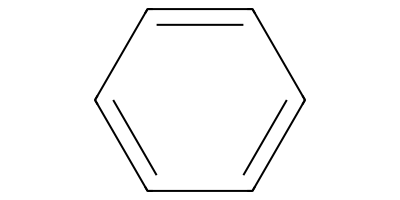

In [68]:
from rdkit import Chem
from rdkit.Chem import Draw

# create a molecule from the MDAnalysis selection
lmol = plf.Molecule.from_mda(lig)
# cleanup before drawing
mol = Chem.RemoveHs(lmol)
mol.RemoveAllConformers()
Draw.MolToImage(mol, size=(400, 200))

# Generate 2D interaction diagram

In [ ]:
from prolif.plotting.network import LigNetwork

fp = plf.Fingerprint()
fp.run(u.trajectory[::10], lig, prot)
df = fp.to_dataframe(return_atoms=True)

net = LigNetwork.from_ifp(
    df,
    lmol,
    # replace with `kind="frame", frame=0` for the other depiction
    kind="aggregate",
    threshold=0.3,
    rotation=270,
)
net.display()

  0%|          | 0/1 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.8/multiprocessing/reduction.py:51: UserWarning: Reader has no dt information, set to 1.0 ps
  cls(buf, protocol).dump(obj)


# Top 3 docked pose ligand extraction

In [ ]:
!grep UNL combined1.pdb > UNL1.pdb
!obabel -ipdb UNL1.pdb -osdf -O UNL1.sdf 
!grep UNL combined2.pdb > UNL2.pdb
!obabel -ipdb UNL2.pdb -osdf -O UNL2.sdf 
!grep UNL combined3.pdb > UNL3.pdb
!obabel -ipdb UNL3.pdb -osdf -O UNL3.sdf 

#### Change ligand name to same as protein name, this is the requirement of Charm GUI HTS

In [ ]:
!mv UNL1.sdf combined1.sdf
!mv UNL2.sdf combined2.sdf
!mv UNL3.sdf combined3.sdf

# Molecular dynamics

## From this point, depends on your needs. If you are confident about pose top 1, then you may want just upload combined.pdb and combined.sdf to solution builder for the purpose of a general simulation 

Or

### If you are not confident about docked pose 1, it is suggested you upload all top 3 poses to High throughtput simulator (HTS)to generate a HTS simulation input file.

## For example, you just want to a general simulation. Upload combined.pdb and UNL.sdf to solution generator to generate MD inputs file
#### Note in the image below, the ligand is still named as UNL.sdf, but for HTS you have to rename it as combined1.sdf

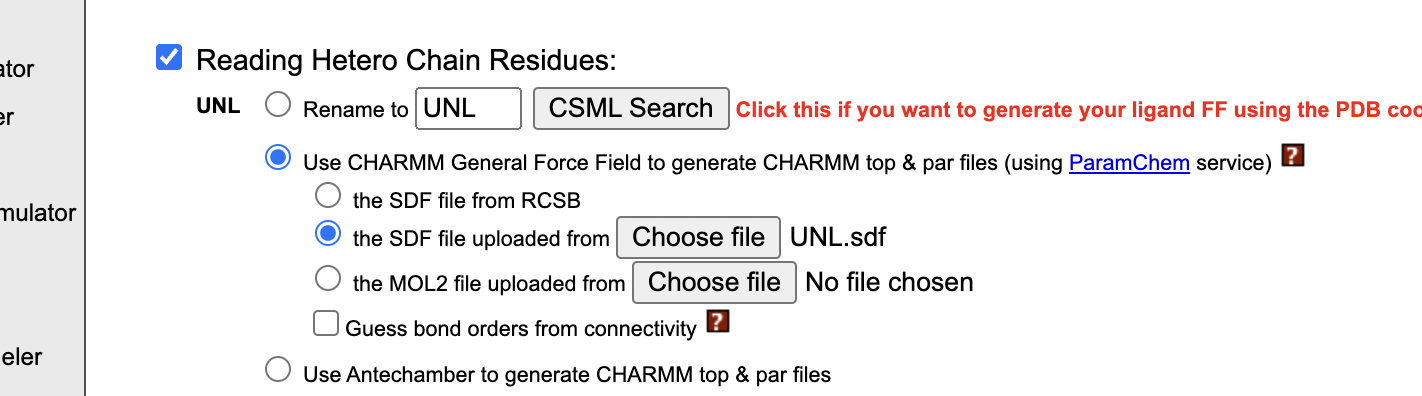

### I recommend OpenMM if you want a suggestion, its speed is one of the best and freely avaliable, for example, https://colab.research.google.com/github/ADicksonLab/ml4md-jb/blob/main/Week-11/CHARMM_GUI_COLAB.ipynb . The likn notebook has not been tested, it maybe tedious with unnecessary packages installation process.

In [ ]:
# Or use https://github.com/pablo-arantes/making-it-rain/blob/main/Protein_ligand.ipynb, just upload receptor.pdb and UNL1.pdb.
# Open and resave receptor.pdb with Pymol if necessary, when there is an error related to mismatched atom numbering.

# Thanks for using this workflow, if you find this is helpful. Please follow https://github.com/quantaosun for more interesting workflows.

# References

All the dependencies used are open soured, they are 

*   rdkit
*   openbabel
*   py3Dmol 
*   pymol-open-source 
*   smina.static
*   MDAnalysis
*   ProLif
*   Python 3.8
*   conda
*   colab conda

- This notebook has referred [Is life worth living](https://www.cheminformania.com/ligand-docking-with-smina/)
- Thi notebook has referred [Jupyter Notebook for docking either locally or using Colab](https://www.macinchem.org/reviews/JupyterDocking/jupyterdocking.php)
 